In [6]:
import cv2
from ultralytics import YOLO
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [83]:
video = 'videos/stolen-car.mp4'
model = YOLO('yolov8n.pt')

cap = cv2.VideoCapture(video)
history = defaultdict(lambda: [])

In [84]:
while cap.isOpened:
    ret, frame = cap.read()
    if ret:

        results = model.track(frame, persist=True)

        if results[0].boxes.id is None:
            continue

        boxes = results[0].boxes.xywh.cpu()
        track_ids = results[0].boxes.id.int().cpu().tolist()
        annotation = results[0].plot()

        for box, track_id in zip(boxes, track_ids):
            x, y, w, h = box
            track = history[track_id]
            track.append((float(x), float(y)))
            if len(track) > 60:
                track.pop(0)

            points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
            cv2.polylines(annotation, [points], isClosed=False, color=(
                230, 230, 230), thickness=5)

        cv2.imshow("Stream: ", annotation)

        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:  # end of video
        break

cap.release()
cv2.destroyAllWindows()


0: 384x640 1 person, 88.5ms
Speed: 4.4ms preprocess, 88.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 17 cars, 1 bus, 80.8ms
Speed: 2.0ms preprocess, 80.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 76.6ms
Speed: 2.0ms preprocess, 76.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 77.0ms
Speed: 1.0ms preprocess, 77.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 75.5ms
Speed: 2.0ms preprocess, 75.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 77.9ms
Speed: 3.2ms preprocess, 77.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 67.6ms
Speed: 1.0ms preprocess, 67.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 5 cars, 67.4ms
Speed: 2.0ms preprocess, 67.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640

[array([     368.27]), array([     408.13,      409.01,      409.93,      411.62,      412.35,      414.94,      417.75,      419.48,         422,      423.12,      425.26,      427.74,      431.06,      432.44,      434.11,      435.71,         438,      438.76,      441.78,      442.88,      444.69,      447.19,      448.28,      451.75,
            453.93,      456.55,      460.72,      463.47,      465.53,      467.36]), array([     338.59,      337.81,       337.1,      336.86,      335.83,      335.17,      335.05,      334.42,      333.78,      333.15,      332.77,      331.93,      331.18,      330.52,      329.65,      329.25,      328.24,       327.3,      326.15,      326.13,      326.06,      325.03,      323.99,      323.25,
            322.79,      321.95,      321.16,      320.46,      319.12,       318.7]), array([     385.07,      386.69,      386.92,      391.55,      391.14,      393.12,      395.22,      396.89,      398.38,      398.92,      403.39,      400.59,   

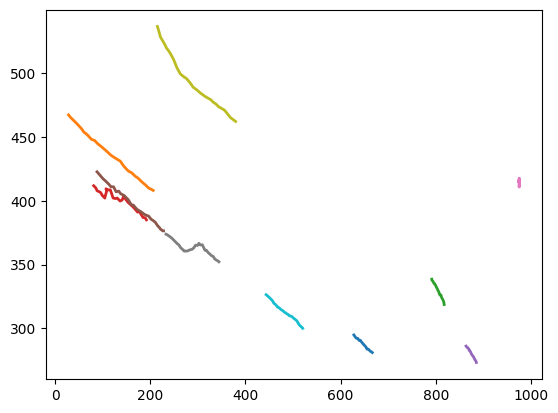

In [85]:
if history:
    fig, ax = plt.subplots()
    # print(history[1])
    # trajectory = np.array(history[1])
    # print(trajectory)
    # ax.plot(trajectory[:, 0], trajectory[:, 1], linewidth=2)
    numpy_history = []
    for track_id, points in history.items():
        points = np.array(points)
        ax.plot(points[:, 0], points[:, 1], linewidth=2)
        numpy_history.append(points)
    # print(numpy_history)
    x_points = [point[:, 0] for point in numpy_history]
    y_points = [point[:, 1] for point in numpy_history]
    print(y_points)
    print(x_points)
    plt.savefig('output_plot.png')

id: 10, (22, 1), mean_squared_error: 0.1836444538453209, r2_score: 0.9897402721791272


c:\Users\Hendrix\GitHub\QHacks2024\env\Lib\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


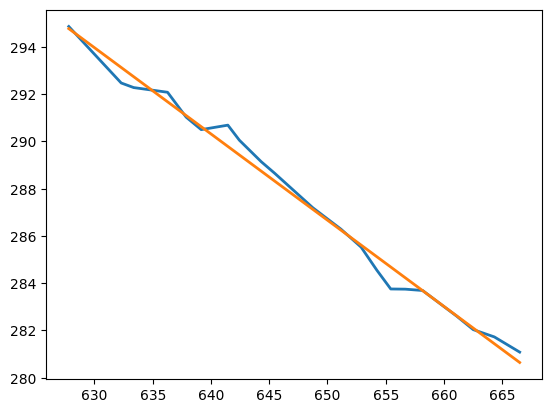

In [88]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

regression = linear_model.LinearRegression()
car_regressions = []
for i, (x, y) in enumerate(zip(x_points, y_points)):
    stats = {}
    x = x.reshape(-1, 1)
    regression.fit(x, y)
    y_pred = regression.predict(x)
    stats['mean_squared_error'] = mean_squared_error(y, y_pred)
    stats['r2_score'] = r2_score(y, y_pred)
    stats['x_vals'] = x
    stats['y_vals'] = y
    stats['y_pred'] = y_pred
    stats['id'] = i
    car_regressions.append(stats)
    # print(stats)

fig, ax = plt.subplots()
car_regressions.sort(key=lambda x: x['mean_squared_error'])
car_reg = car_regressions[2]
print(f"id: {i}, {car_reg['x_vals'].shape}, mean_squared_error: {car_reg['mean_squared_error']}, r2_score: {car_reg['r2_score']}")
ax.plot(car_reg['x_vals'], car_reg['y_vals'], linewidth=2)
ax.plot(car_reg['x_vals'], car_reg['y_pred'], linewidth=2)

